In [4]:
from importlib import reload
from load_cluster_data import load_cluster_data
from pca_kmeans_init import pca_kmeans_init
from betabinomo_mix_singlecells import *
import betabinomo_mix_singlecells
reload(betabinomo_mix_singlecells)
import torch
import sklearn.manifold 
import plotnine as p9
import time
# indicate plot should be small 4 by 4
import plotnine as p9
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, geom_violin, theme, element_blank
import plotnine
plotnine.options.figure_size = (4, 4)

### Settings and Load data

In [5]:
input_file = '/gpfs/commons/scratch/kisaev/ss_tabulamuris_test/Leaflet/brain_mouse_cells_noanno.h5'

torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

MAKE_PCA_TSNE = True

float_type = { 
    "device" : device, 
    "dtype" : torch.float, # save memory
}

hypers = {
    "eta" : 1., 
    "alpha_prior" : 1., # karin had 0.65 
    "pi_prior" : 1.
}

cpu


In [6]:
final_data, coo_counts_sparse, coo_cluster_sparse, cell_ids_conversion, junction_ids_conversion = load_cluster_data(
    input_file) 
N = coo_cluster_sparse.shape[0]
J = coo_cluster_sparse.shape[1]

cell_index_tensor, junc_index_tensor, my_data = betabinomo_mix_singlecells.make_torch_data(final_data, **float_type)

['Brain_Myeloid_macrophage_pseudobulk'
 'Brain_Non-Myeloid_Bergmann_glial_cell_pseudobulk'
 'Brain_Non-Myeloid_astrocyte_pseudobulk'
 'Brain_Non-Myeloid_brain_pericyte_pseudobulk'
 'Brain_Non-Myeloid_endothelial_cell_pseudobulk'
 'Brain_Non-Myeloid_neuron_pseudobulk'
 'Brain_Non-Myeloid_oligodendrocyte_precursor_cell_pseudobulk'
 'Brain_Non-Myeloid_oligodendrocyte_pseudobulk']
3462
3462
63257
63257
The number of junctions in the data is:  63257
The number of cells in the data is:  3462
The number of cell types in the data is:  8


In [7]:
num_trials = 1 # should also be an argument that gets fed in
num_iters = 100 # should also be an argument that gets fed in
K = 10 

# loop over the number of trials (for now just testing using one trial but in general need to evaluate how performance is affected by number of trials)
reload(betabinomo_mix_singlecells)

start_time = time.time()
results = [ betabinomo_mix_singlecells.calculate_CAVI(K, my_data, float_type, hypers, init_labels = None, num_iterations = num_iters) 
           for t in range(num_trials) ]
print(time.time() - start_time)

Initialize VI params
Got the initial ELBO ^
ELBO converged @ -1675629056.0  CAVI iteration #  100  complete
53.7968909740448


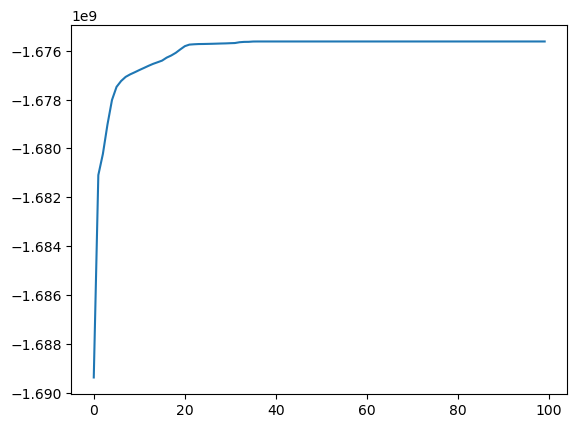

In [8]:
best = np.argmax([ g[-1][-1] for g in results ]) # final ELBO
ALPHA_f, PI_f, GAMMA_f, PHI_f, elbos_all = results[best]
elbos_all = np.array(elbos_all)
plt.plot(elbos_all[1:]); plt.show()

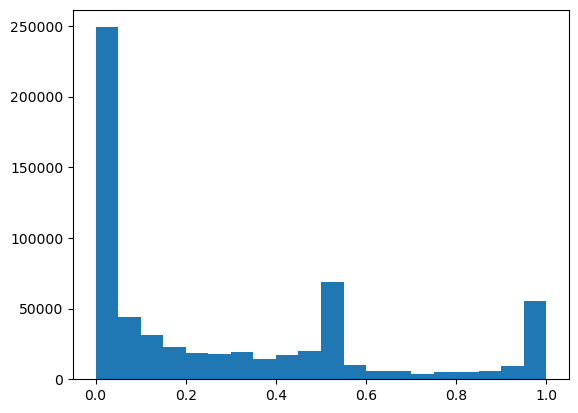

In [9]:
juncs_probs = ALPHA_f / (ALPHA_f+PI_f)    
plt.hist(juncs_probs.cpu().numpy().flatten(), 20); plt.show()

In [10]:
theta_f_plot = pd.DataFrame(PHI_f.cpu().numpy())
theta_f_plot['cell_id'] = cell_ids_conversion["cell_type"].to_numpy()
theta_f_plot_summ = theta_f_plot.groupby('cell_id').mean()
print(theta_f_plot_summ)

                                                           0         1  \
cell_id                                                                  
Brain_Myeloid_macrophage_pseudobulk                 0.114754  0.032787   
Brain_Non-Myeloid_Bergmann_glial_cell_pseudobulk    0.000000  0.000000   
Brain_Non-Myeloid_astrocyte_pseudobulk              0.006944  0.009259   
Brain_Non-Myeloid_brain_pericyte_pseudobulk         0.006410  0.006410   
Brain_Non-Myeloid_endothelial_cell_pseudobulk       0.013986  0.009790   
Brain_Non-Myeloid_neuron_pseudobulk                 0.024911  0.010676   
Brain_Non-Myeloid_oligodendrocyte_precursor_cel...  0.891626  0.029557   
Brain_Non-Myeloid_oligodendrocyte_pseudobulk        0.032402  0.073698   

                                                           2         3  \
cell_id                                                                  
Brain_Myeloid_macrophage_pseudobulk                 0.032787  0.016393   
Brain_Non-Myeloid_Bergmann_glial_cell

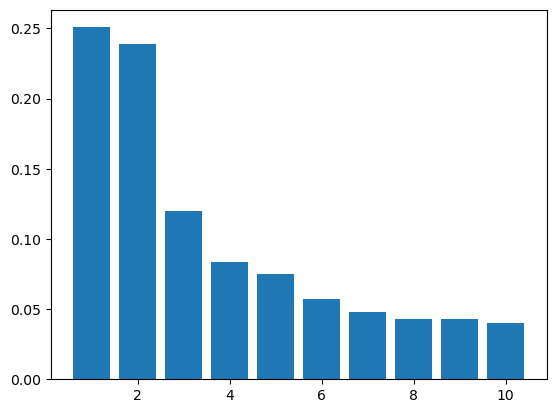

In [11]:
# How much each cluster is used in each "cell state"
theta = GAMMA_f / GAMMA_f.sum()
theta = theta.cpu().numpy()
theta_sorted = np.sort(theta)
plt.bar(np.arange(K)+1,theta_sorted[::-1]); plt.show()

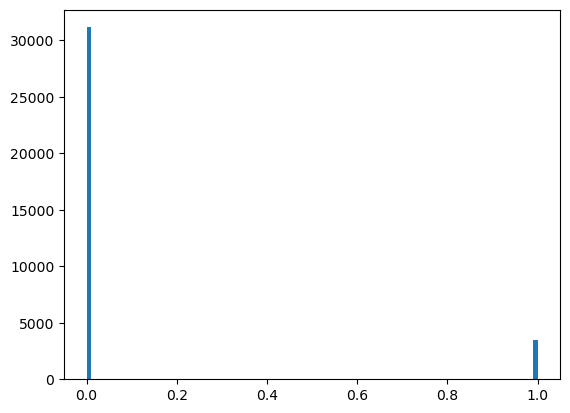

In [12]:
to_keep = theta > 0.04

x = PHI_f.cpu().numpy()
x = x[:,to_keep]
#x -= x.mean(1,keepdims=True)
#x /= x.std(1,keepdims=True)
_ = plt.hist(x.flatten(),100)

<Figure size 1000x800 with 0 Axes>

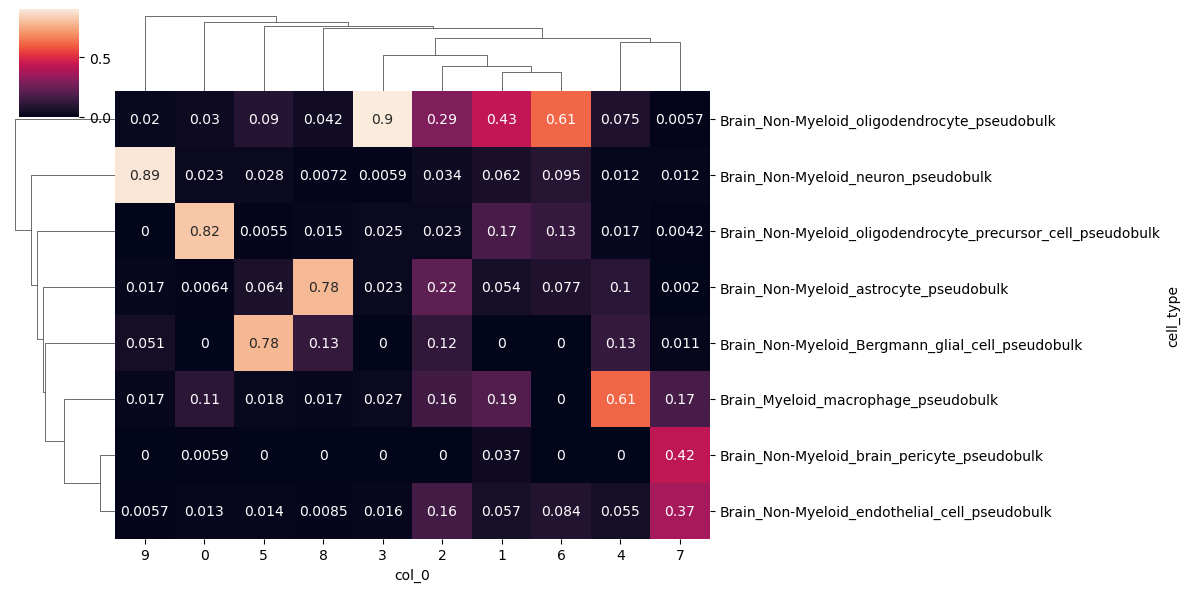

In [13]:
ct = pd.crosstab( cell_ids_conversion["cell_type"], x.argmax(axis=1) )
ct_np = ct.to_numpy()

ct_np = ct_np / ct_np.sum(1, keepdims=True) # normalize cell-type counts
ct_np = ct_np / ct_np.sum(0, keepdims=True)

ct.iloc[:,:] = ct_np

ax = plt.figure(figsize=[10,8])
sns.clustermap(ct, dendrogram_ratio=0.15, vmin = None, figsize=(12,6), annot = True)

In [14]:
juncs_probs

tensor([[9.9595e-01, 9.9123e-01, 9.3098e-01,  ..., 9.9086e-01, 9.9324e-01,
         9.9773e-01],
        [4.0486e-03, 8.7719e-03, 6.9024e-02,  ..., 9.1426e-03, 6.7568e-03,
         2.2676e-03],
        [3.2664e-01, 4.2604e-01, 3.9127e-01,  ..., 4.6919e-01, 5.4315e-01,
         4.6355e-01],
        ...,
        [1.4711e-02, 1.2987e-02, 2.0576e-02,  ..., 3.2609e-03, 1.7672e-02,
         3.9224e-02],
        [3.2690e-04, 1.8553e-03, 2.0576e-03,  ..., 5.9783e-03, 7.2765e-03,
         5.7294e-03],
        [3.1056e-01, 2.8200e-01, 1.2140e-01,  ..., 1.5598e-01, 2.0166e-01,
         1.5029e-01]])

In [15]:
juncs_probs_df = pd.DataFrame(juncs_probs, columns = range(K))
# add "cell_state" to each column name 
juncs_probs_df.columns = ["cell_state_" + str(col) for col in juncs_probs_df.columns]
juncs_probs_df["junction_id_index"] = junction_ids_conversion.junction_id_index.values
# convert to juncs_probs to pandas dataframe and calculate mean and std across cell states/topics
juncs_probs_df["junction_id"] = junction_ids_conversion.junction_id.values

def plot_juncObsUsage(junc_index):

    # print junction ID using junction_ids_conversion
    print(junction_ids_conversion[junction_ids_conversion["junction_id_index"] == junc_index])
    junc_id = junction_ids_conversion[junction_ids_conversion["junction_id_index"] == junc_index].junction_id.values[0]

    # get data for just junc_index 
    junc_dat=final_data[final_data.junction_id_index==junc_index]

    # make violin plot for junc_dat junction usage ratio coloured by cell_type and rotate plot 90 degrees
    plot = ggplot(junc_dat, aes(x='cell_type', y='juncratio', fill="cell_type")) + geom_violin() + geom_point() + plotnine.labels.ggtitle(junc_id) + plotnine.coords.coord_flip() 
    print(plot)

def plot_juncProbs(junc_index):
    
    # print junction ID using junction_ids_conversion
    print(junction_ids_conversion[junction_ids_conversion["junction_id_index"] == junc_index])
    junc_id = junction_ids_conversion[junction_ids_conversion["junction_id_index"] == junc_index].junction_id.values[0]
    
    # get data for just junc_index 
    junc_dat=juncs_probs_df[juncs_probs_df.junction_id_index==junc_index]
    junc_dat = junc_dat.melt().iloc[0:K]
    junc_dat.value = junc_dat.value.astype(float)
    # make violin plot for junc_dat junction usage ratio coloured by cell_type
    # don't print x-axis tick labels 
    plot = ggplot(junc_dat, aes(x='variable', y='value')) + geom_point() + theme(axis_text_x=element_blank())
    print(plot)

In [16]:
# calculate sd deviation for each junction for cell states 0 to 19 
juncs_probs_df["sd"] = juncs_probs_df.iloc[:,0:K].std(axis=1)


In [17]:
# write function that takes in cell state and returns top 10 junctions with the highest difference with all other K-1 cell states
def top10_juncs(cell_state):
    # for each junction get the difference between cell_state and all other cell states not including cell_state
    # return top 10 junctions with highest difference
    no_ref=juncs_probs_df[juncs_probs_df.columns[~juncs_probs_df.columns.isin([cell_state, "junction_id_index", "junction_id", "sd"])]]
    juncs_probs_df["diff"] = juncs_probs_df[cell_state] - no_ref.mean(axis=1)
    top10 = juncs_probs_df.sort_values(by="diff", ascending=False).head(10)
    return(top10.junction_id_index.values)

In [21]:
top10juncs_state1 = top10_juncs("cell_state_9")

In [22]:
top10juncs_state1

array([ 7172, 53741, 43109, 12335, 52061, 21663, 44799, 40763,  2827,
        9543])

         junction_id_index           junction_id  Cluster
1219859               7172  11_94112146_94114172    81203


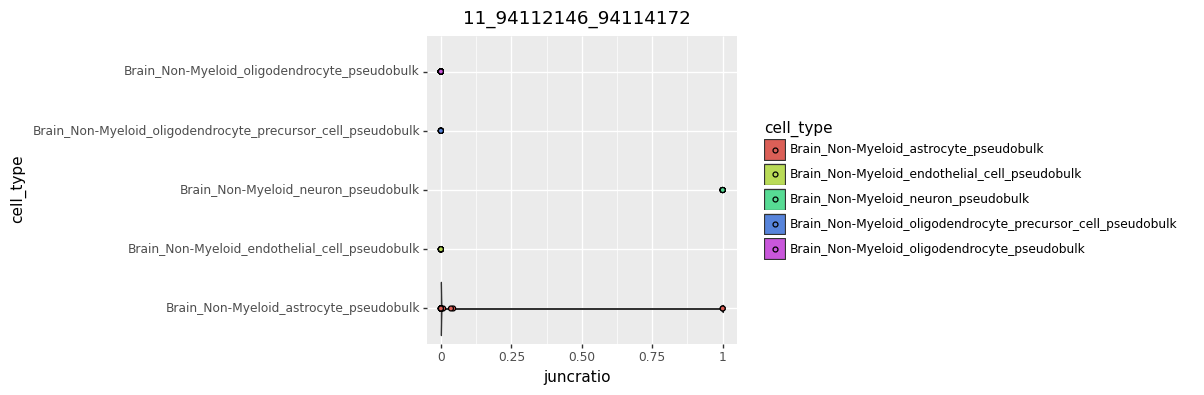


         junction_id_index           junction_id  Cluster
1219859               7172  11_94112146_94114172    81203


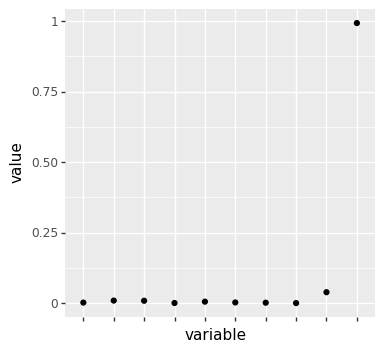


         junction_id_index          junction_id  Cluster
5491387              53741  7_90387556_90392358    50864


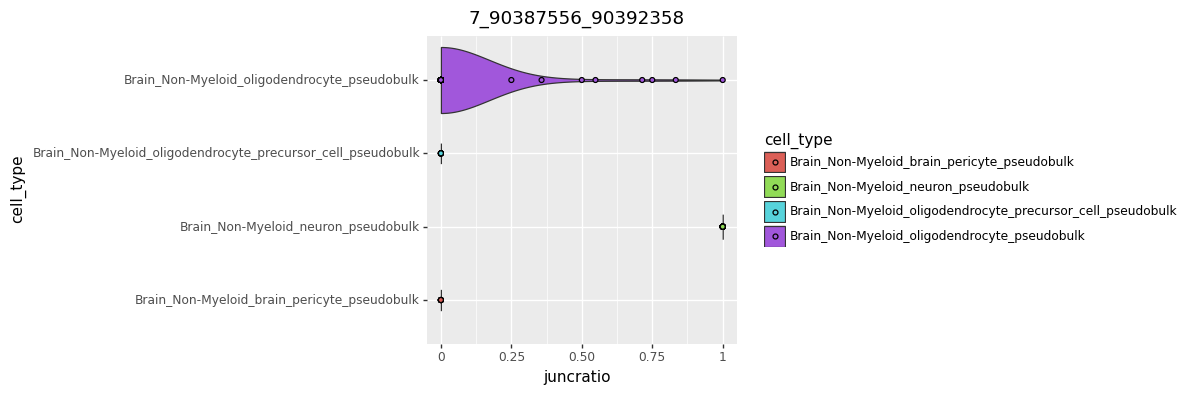


         junction_id_index          junction_id  Cluster
5491387              53741  7_90387556_90392358    50864


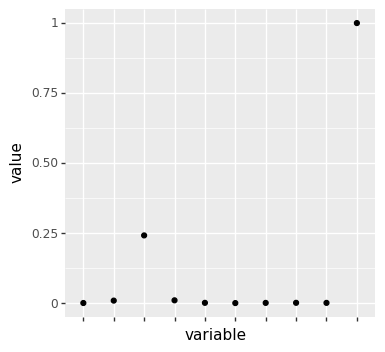


         junction_id_index            junction_id  Cluster
8721671              43109  5_128447762_128448558    36911


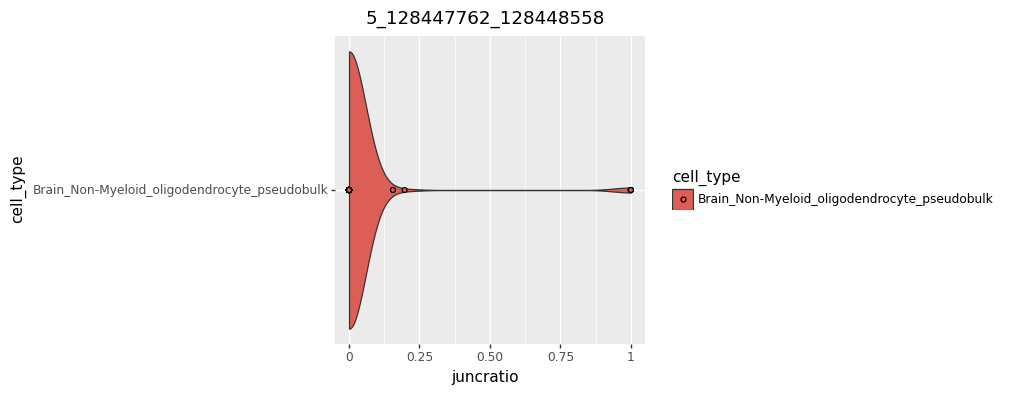


         junction_id_index            junction_id  Cluster
8721671              43109  5_128447762_128448558    36911


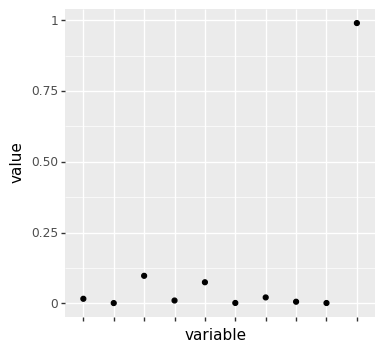


         junction_id_index           junction_id  Cluster
5742057              12335  14_20294792_20295087    97883


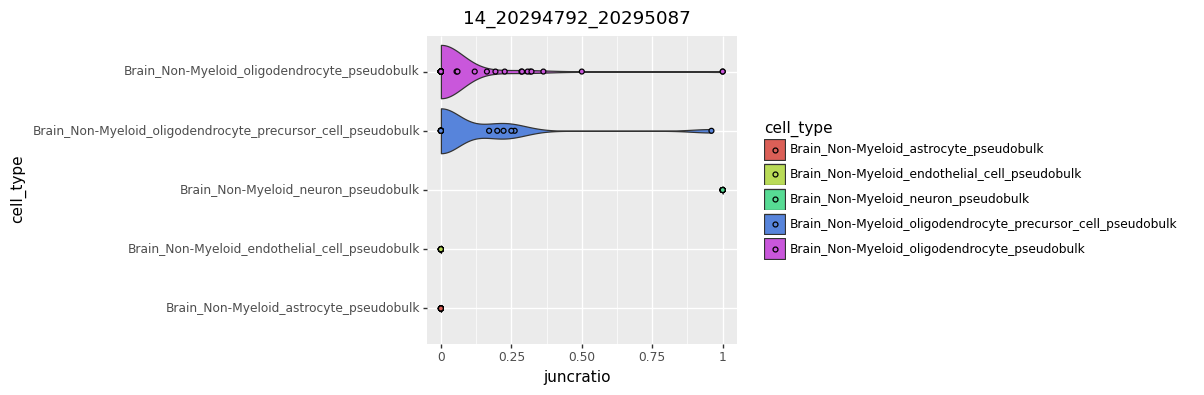


         junction_id_index           junction_id  Cluster
5742057              12335  14_20294792_20295087    97883


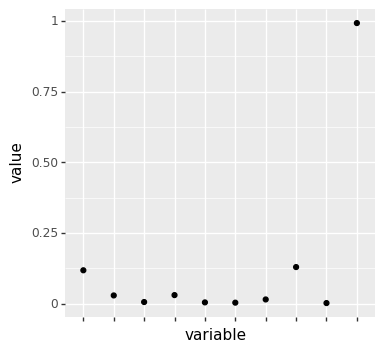


         junction_id_index          junction_id  Cluster
5468826              52061  7_35353057_35361564    49670


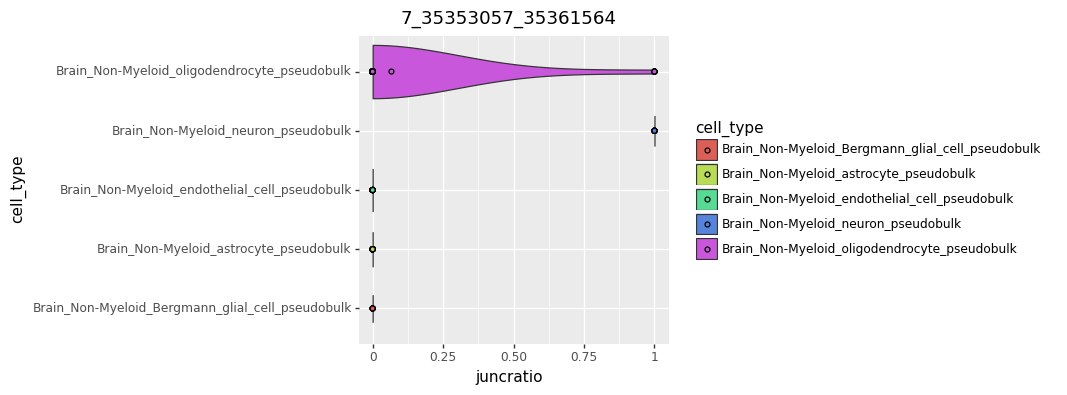


         junction_id_index          junction_id  Cluster
5468826              52061  7_35353057_35361564    49670


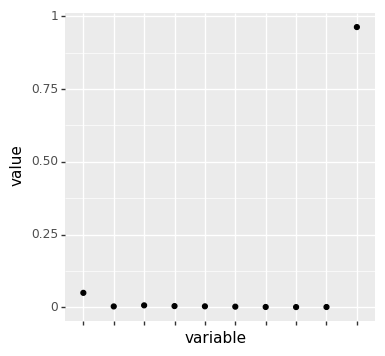


         junction_id_index         junction_id  Cluster
5836535              21663  17_8298637_8311016   115656


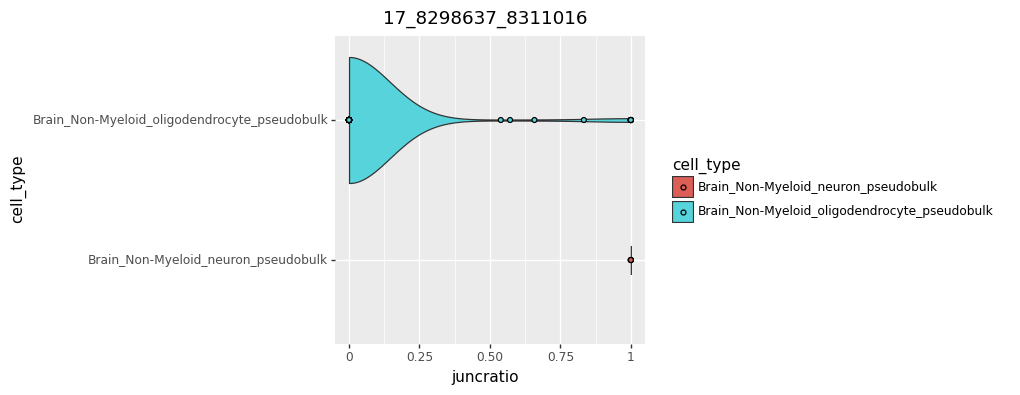


         junction_id_index         junction_id  Cluster
5836535              21663  17_8298637_8311016   115656


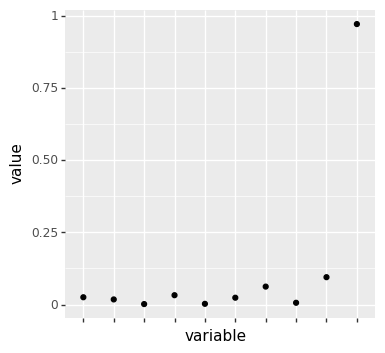


         junction_id_index          junction_id  Cluster
5474839              44799  5_34549796_34551560    34470


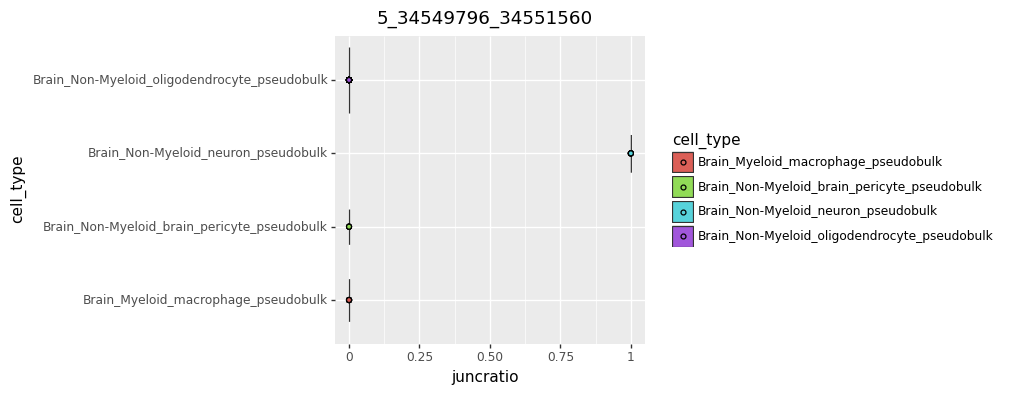


         junction_id_index          junction_id  Cluster
5474839              44799  5_34549796_34551560    34470


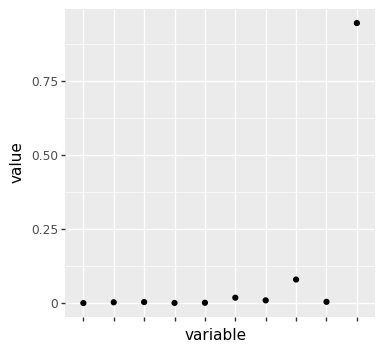


         junction_id_index          junction_id  Cluster
5489899              40763  4_35710013_35890025    29657


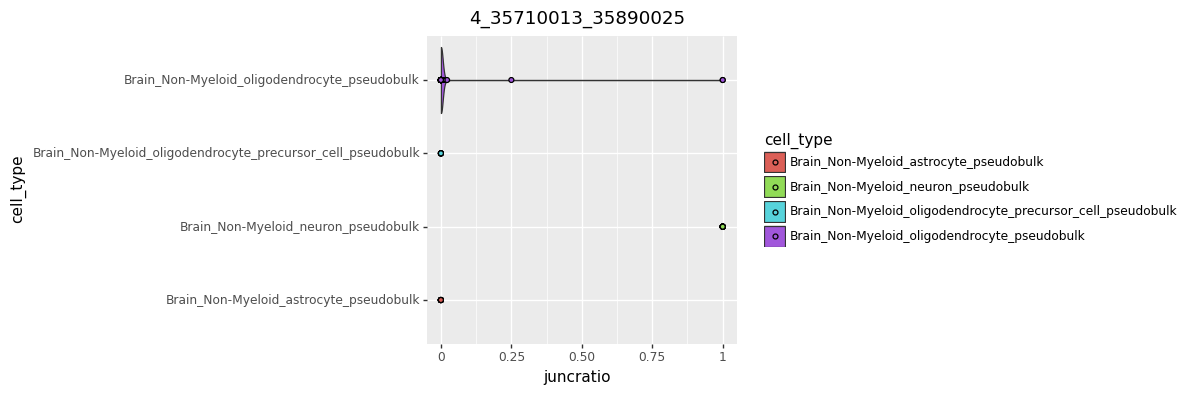


         junction_id_index          junction_id  Cluster
5489899              40763  4_35710013_35890025    29657


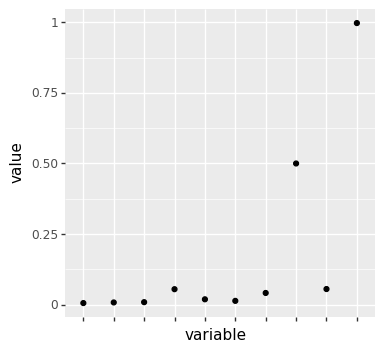


         junction_id_index         junction_id  Cluster
5539971               2827  10_9778071_9789362    74848


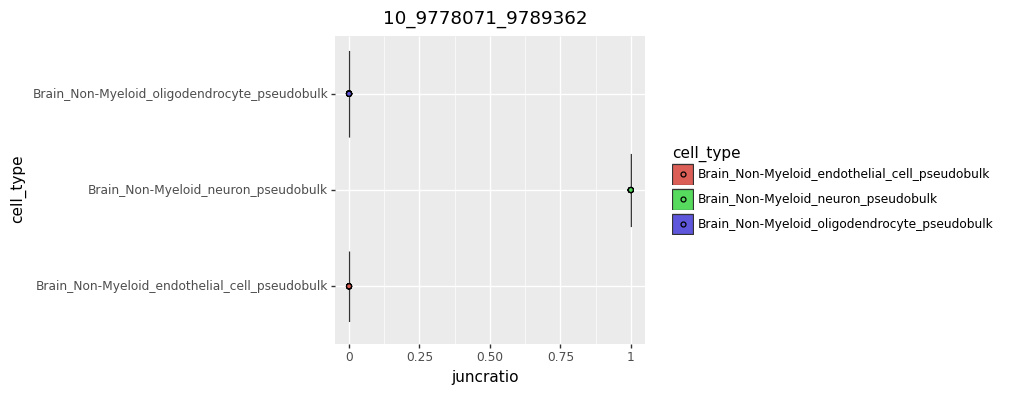


         junction_id_index         junction_id  Cluster
5539971               2827  10_9778071_9789362    74848


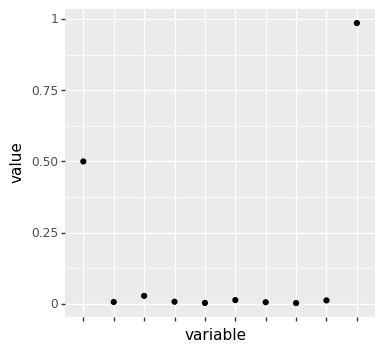


         junction_id_index           junction_id  Cluster
8477747               9543  12_85917832_85918972    90247


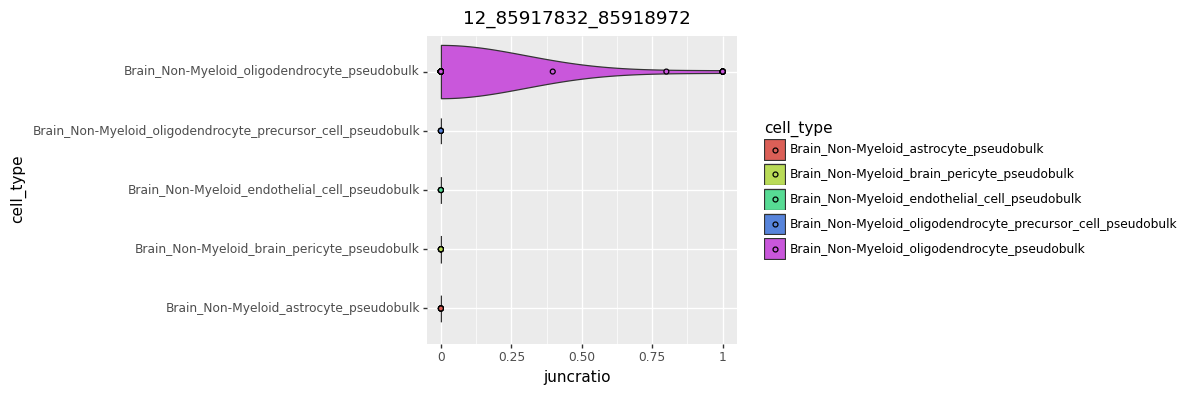


         junction_id_index           junction_id  Cluster
8477747               9543  12_85917832_85918972    90247


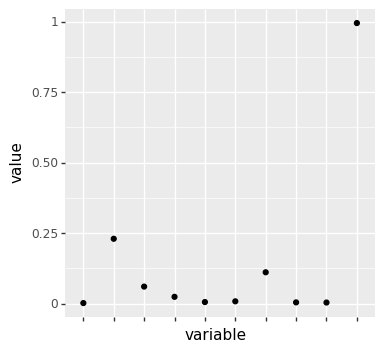

In [23]:
# for each junction in top10juncs_state1, run plot_juncObsUsage and plot_juncProbs
for junc in top10juncs_state1:
    plot_juncObsUsage(junc)
    plot_juncProbs(junc)